## Implementação do artigo, visando um melhor entendimento para criação de um tutorial adequado para aqueles que pretendem reproduzí-lo.

### **Título:**
## Training and Meta-Training Binary Neural Networks with Quantum Computing

### **Autores:**
Fawaz, Abdulah, et al.

### **Grupo que criou o resumo e tutorial:**
André, Daivid e Felipe


# **Passo FeedFoward da Rede**

## Inicializando o qiskit e verificando os backends disponíveis.

In [1]:
## matplotlib to see the circuits
%matplotlib inline
## qiskit standart
from qiskit import *

In [2]:
## See available eviroments
Aer.backends()

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

### Objetivo deste Jupyter

Queremos ao final construir uma rede feedfoward entendendo cada parte da rede e o circuito criado.

- Utilizar os conhecimentos anteriores sobre Redes Neurais;
- Devemos otimizar o sistema em relação a quantidade de quBits utilizados

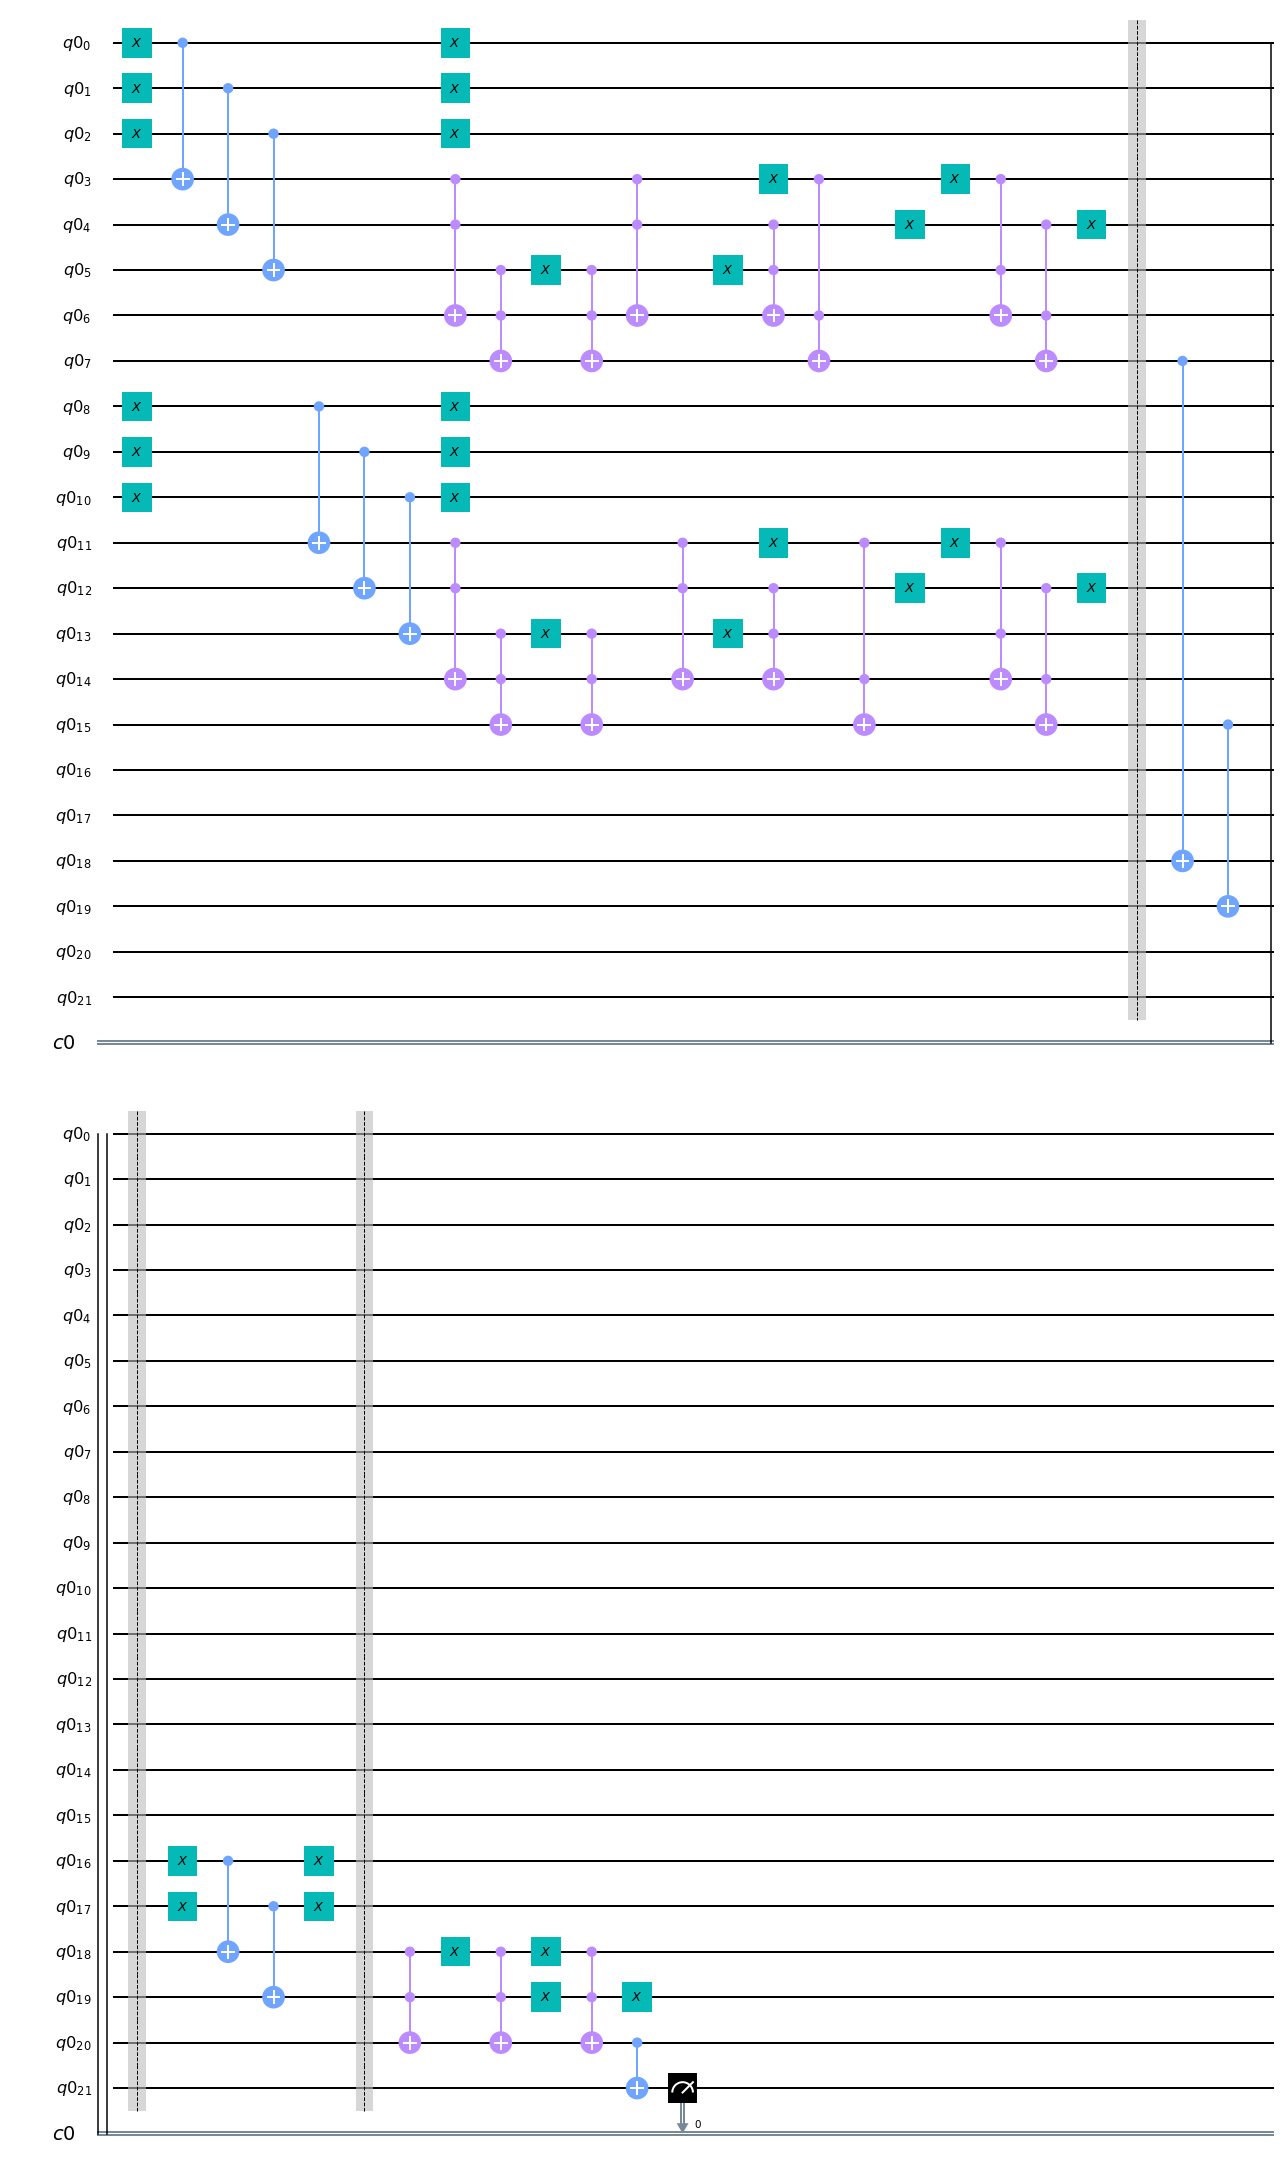

In [3]:
# Array com 8 bits quânticos
# Os 3 [0 - 2] primeiros representam pesos
# Os 3 seguintes [3 - 5] representam inputs
# O penúltimo uma ancila e o último o qubit resultante
# Note que o Qubit resultante é o resultado após a função de ativação

# Definindo a multiplicação de um peso por uma entrada.
def multiplyWeightInput(circuit, x, y):
    circuit.x(x)
    circuit.cx(x, y)
    circuit.x(x)

def activationFunction(circuit, listaQubit):
    circuit.ccx(listaQubit[0], listaQubit[1], listaQubit[3])
    circuit.ccx(listaQubit[2], listaQubit[3], listaQubit[4])
    circuit.x(listaQubit[2])
    circuit.ccx(listaQubit[2], listaQubit[3], listaQubit[4])
    circuit.x(listaQubit[2])
    circuit.ccx(listaQubit[0], listaQubit[1], listaQubit[3])
    circuit.ccx(listaQubit[1], listaQubit[2], listaQubit[3])
    circuit.x(listaQubit[0])
    circuit.ccx(listaQubit[0], listaQubit[3], listaQubit[4])
    circuit.x(listaQubit[0])
    circuit.ccx(listaQubit[0], listaQubit[2], listaQubit[3])
    circuit.x(listaQubit[1])
    circuit.ccx(listaQubit[1], listaQubit[3], listaQubit[4])
    circuit.x(listaQubit[1])

# Supondo que os valores iniciais são |0>
qWI = QuantumRegister(22) 
c = ClassicalRegister(1)
# Construindo o circuito
circuit = QuantumCircuit(qWI, c)
# Definindo a quantidade de inputs
qtd_input = 3

# Então, aqui temos a implementação do primeiro perceptron com 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i + qtd_input]) for i in range(qtd_input)]

# Vejamos o segundo perceptron que também tem 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i + qtd_input]) for i in range(8, 11)]

activationFunction(circuit, qWI[3:8])
activationFunction(circuit, qWI[11:16])
circuit.barrier()
circuit.cx(qWI[7], qWI[18])
circuit.cx(qWI[15], qWI[19])
circuit.barrier()

multiplyWeightInput(circuit, qWI[16], qWI[18])
multiplyWeightInput(circuit, qWI[17], qWI[19])
circuit.barrier()

circuit.ccx(qWI[18], qWI[19], qWI[20])
circuit.x(qWI[18])
circuit.ccx(qWI[18], qWI[19], qWI[20])
circuit.x(qWI[18])
circuit.x(qWI[19])
circuit.ccx(qWI[18], qWI[19], qWI[20])
circuit.x(qWI[19])

circuit.cx(qWI[20],qWI[21])

circuit.measure(qWI[21], c[0])

# -----------------------------------------
# Ver o circuit desenhado
circuit.draw(output="mpl")

In [4]:
#Executando o circuito
backend = BasicAer.get_backend('qasm_simulator')
job = qiskit.execute(circuit, backend, shots=10)
result = job.result()
counts = result.get_counts(circuit)
print(counts)

{'0': 10}


#### Pensando no melhoramento da performance do algoritmo, em questões de utilização de quBits.

Bem, acima temos o modelo que foi utilizado na versão 1, e aos poucos vamos tentar reduzir a quantidade de quBits utilizandos para a contrução da Rede. Podemos perceber que a entrado do circuito para a rede, será sempre a mesma e que só precisamos reinicializar os quBits para o estado inicial da entrada, logo temos: 

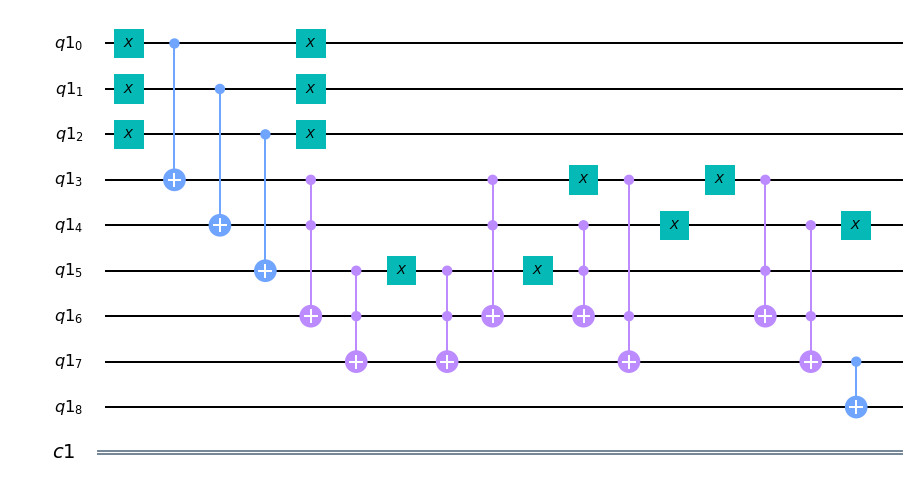

In [5]:
# Supondo que os valores iniciais são |0>
qWI = QuantumRegister(9) 
c = ClassicalRegister(1)
# Construindo o circuito
circuit = QuantumCircuit(qWI, c)
# Definindo a quantidade de inputs
qtd_input = 3

# Então, aqui temos a implementação do primeiro perceptron com 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i + qtd_input]) for i in range(qtd_input)]
activationFunction(circuit, qWI[3:8])
circuit.cx(qWI[7], qWI[8])

# -----------------------------------------
# Ver o circuit desenhado
circuit.draw(output="mpl")

#### Para 1 perceptron e seus respectivos pesos e entradas foram necessários somente 9 quBits contando com suas ancillas.

Vejamos então, como podemos reutilizar os quBits de entradas, os utilizados para a função de ativação e as ancillas.

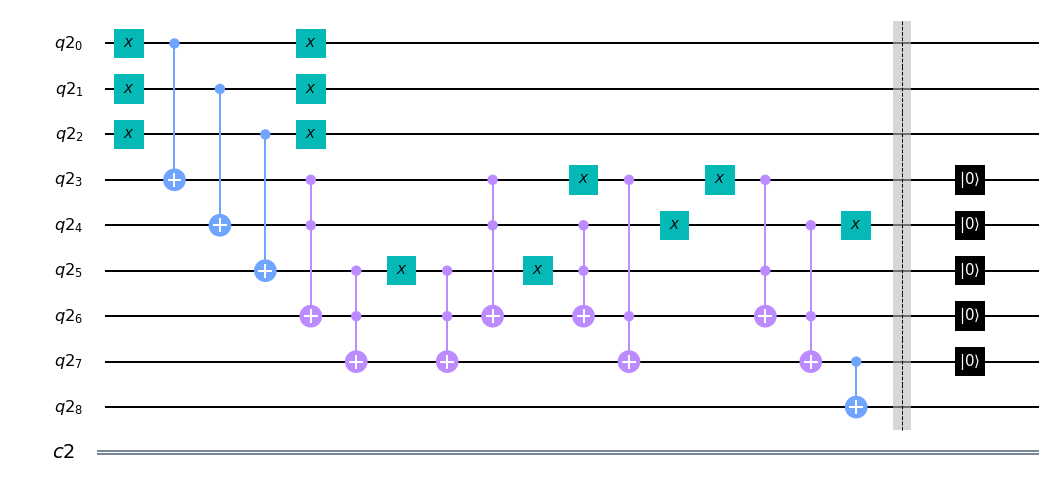

In [6]:
# Supondo que os valores iniciais são |0>
qWI = QuantumRegister(9) 
c = ClassicalRegister(1)
# Construindo o circuito
circuit = QuantumCircuit(qWI, c)
# Definindo a quantidade de inputs
qtd_input = 3

# Então, aqui temos a implementação do primeiro perceptron com 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i + qtd_input]) for i in range(qtd_input)]
activationFunction(circuit, qWI[3:8])
circuit.cx(qWI[7], qWI[8])

circuit.barrier()
circuit.reset(qWI[3:8])

# -----------------------------------------
# Ver o circuit desenhado
circuit.draw(output="mpl")


#### O que foi feito?
Com a função ".reset()" reinicializamos 5 quBits para seu estado original e podemos reutilizá-los ao invés de ter que utilizar novos quBits. Além disso, note que não resetamos o quBit com a saída do perceptron.

Em seguida temos.

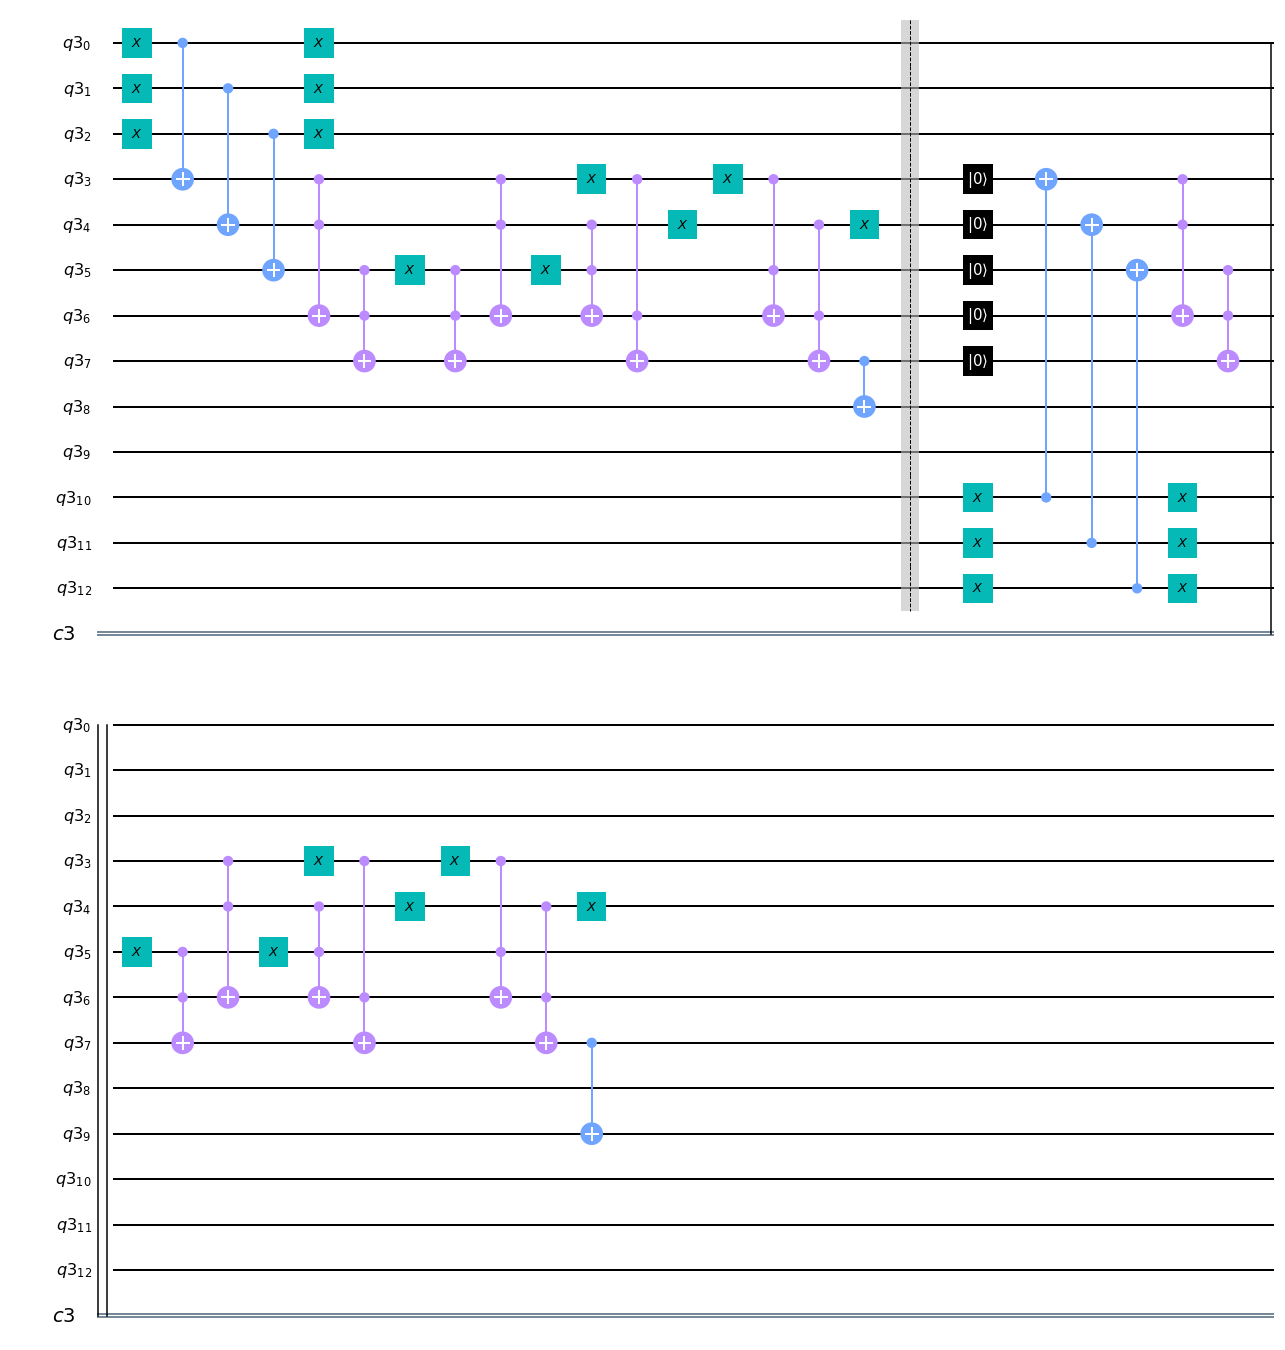

In [7]:
# Supondo que os valores iniciais são |0>
qWI = QuantumRegister(13) 
c = ClassicalRegister(1)
# Construindo o circuito
circuit = QuantumCircuit(qWI, c)
# Definindo a quantidade de inputs
qtd_input = 3

# Então, aqui temos a implementação do primeiro perceptron com 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i + qtd_input]) for i in range(qtd_input)]
activationFunction(circuit, qWI[3:8])
circuit.cx(qWI[7], qWI[8])

circuit.barrier()

circuit.reset(qWI[3:8])

# Vejamos o segundo perceptron que também tem 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i - qtd_input - 4]) for i in range(10, 13)]
activationFunction(circuit, qWI[3:8])
#circuit.barrier()
circuit.cx(qWI[7], qWI[9])
#circuit.barrier()

# -----------------------------------------
# Ver o circuit desenhado
circuit.draw(output="mpl")


#### Desse modo, conseguimos reutilizar 5 qubits e reduzir 3 neurônios.

E ao final, podemos utilizar os mesmo 5 quBits para obter a saída da rede, adicionando somente 1 qubit, que será a nossa saída, logo temos:

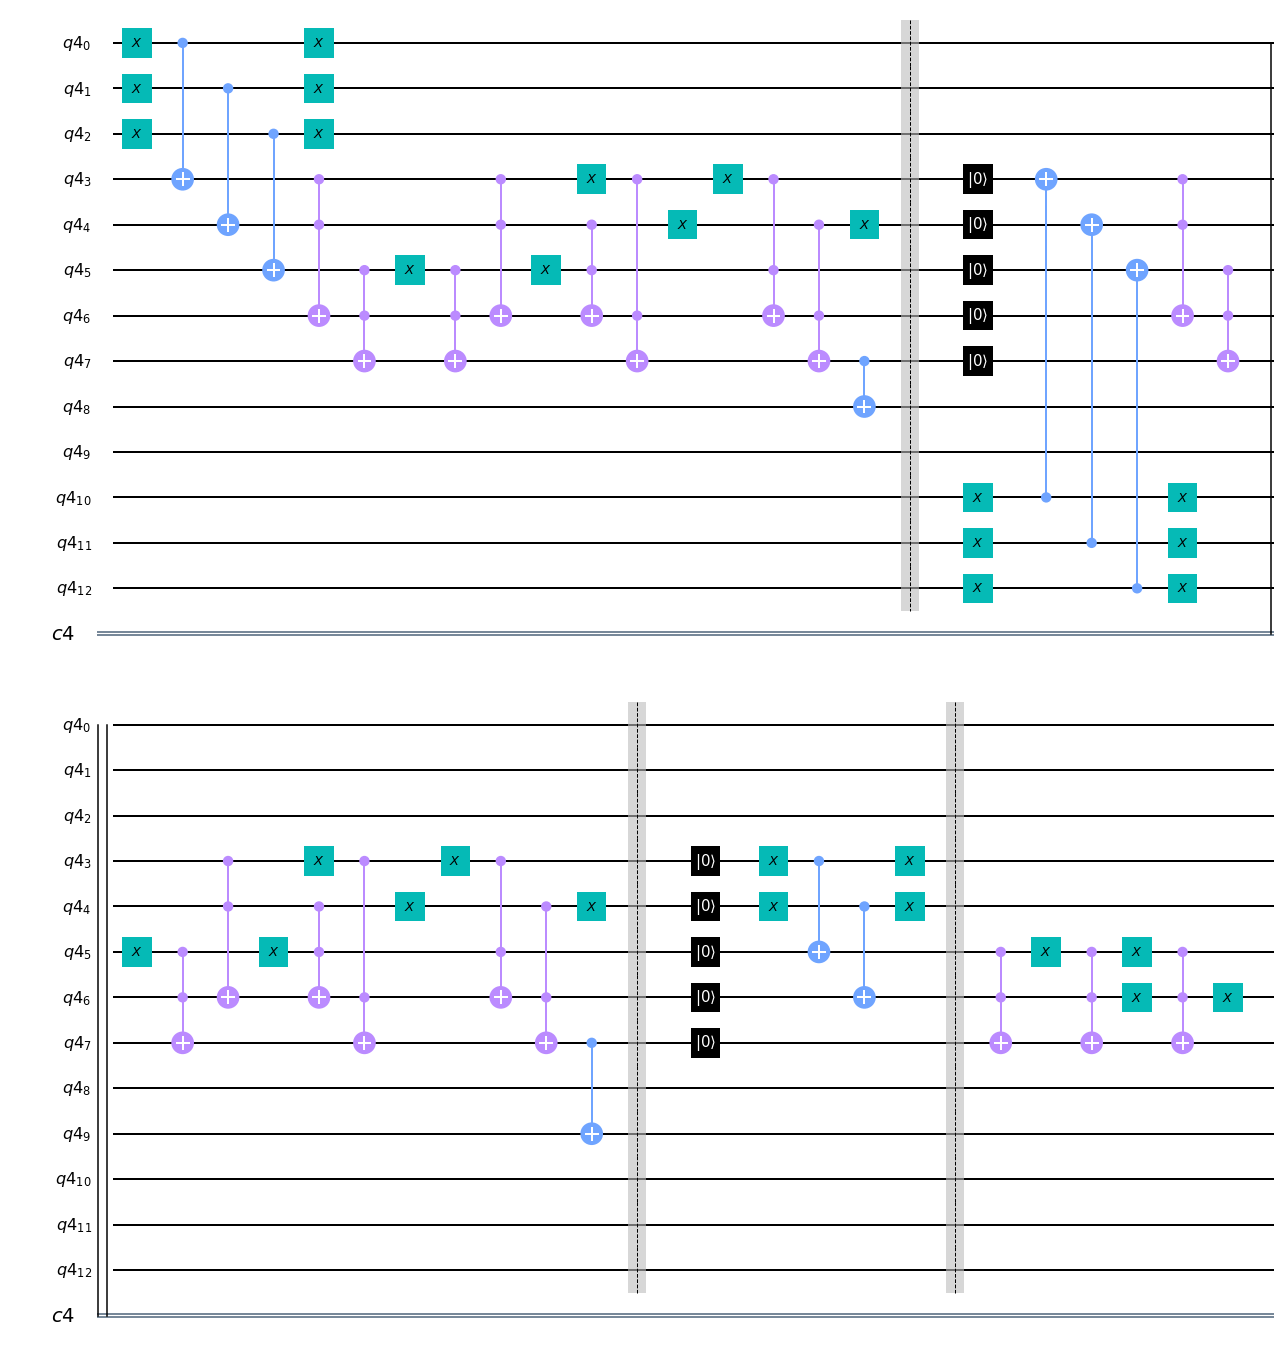

In [8]:
# Supondo que os valores iniciais são |0>
qWI = QuantumRegister(13) 
c = ClassicalRegister(1)
# Construindo o circuito
circuit = QuantumCircuit(qWI, c)
# Definindo a quantidade de inputs
qtd_input = 3

# Então, aqui temos a implementação do primeiro perceptron com 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i + qtd_input]) for i in range(qtd_input)]
activationFunction(circuit, qWI[3:8])
circuit.cx(qWI[7], qWI[8])

circuit.barrier()

circuit.reset(qWI[3:8])

# Vejamos o segundo perceptron que também tem 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i - qtd_input - 4]) for i in range(10, 13)]
activationFunction(circuit, qWI[3:8])
#circuit.barrier()
circuit.cx(qWI[7], qWI[9])
circuit.barrier()

circuit.reset(qWI[3:8])

multiplyWeightInput(circuit, qWI[3], qWI[5])
multiplyWeightInput(circuit, qWI[4], qWI[6])
circuit.barrier()

circuit.ccx(qWI[5], qWI[6], qWI[7])
circuit.x(qWI[5])
circuit.ccx(qWI[5], qWI[6], qWI[7])
circuit.x(qWI[5])
circuit.x(qWI[6])
circuit.ccx(qWI[5], qWI[6], qWI[7])
circuit.x(qWI[6])

# -----------------------------------------
# Ver o circuit desenhado
circuit.draw(output="mpl")


##### Perceba que pudemos utilizar os últimos como pesos, pois não vamos zerar novamente os quBits.

A medição da saída precisará ser realizada, logo, em código completo temos: 

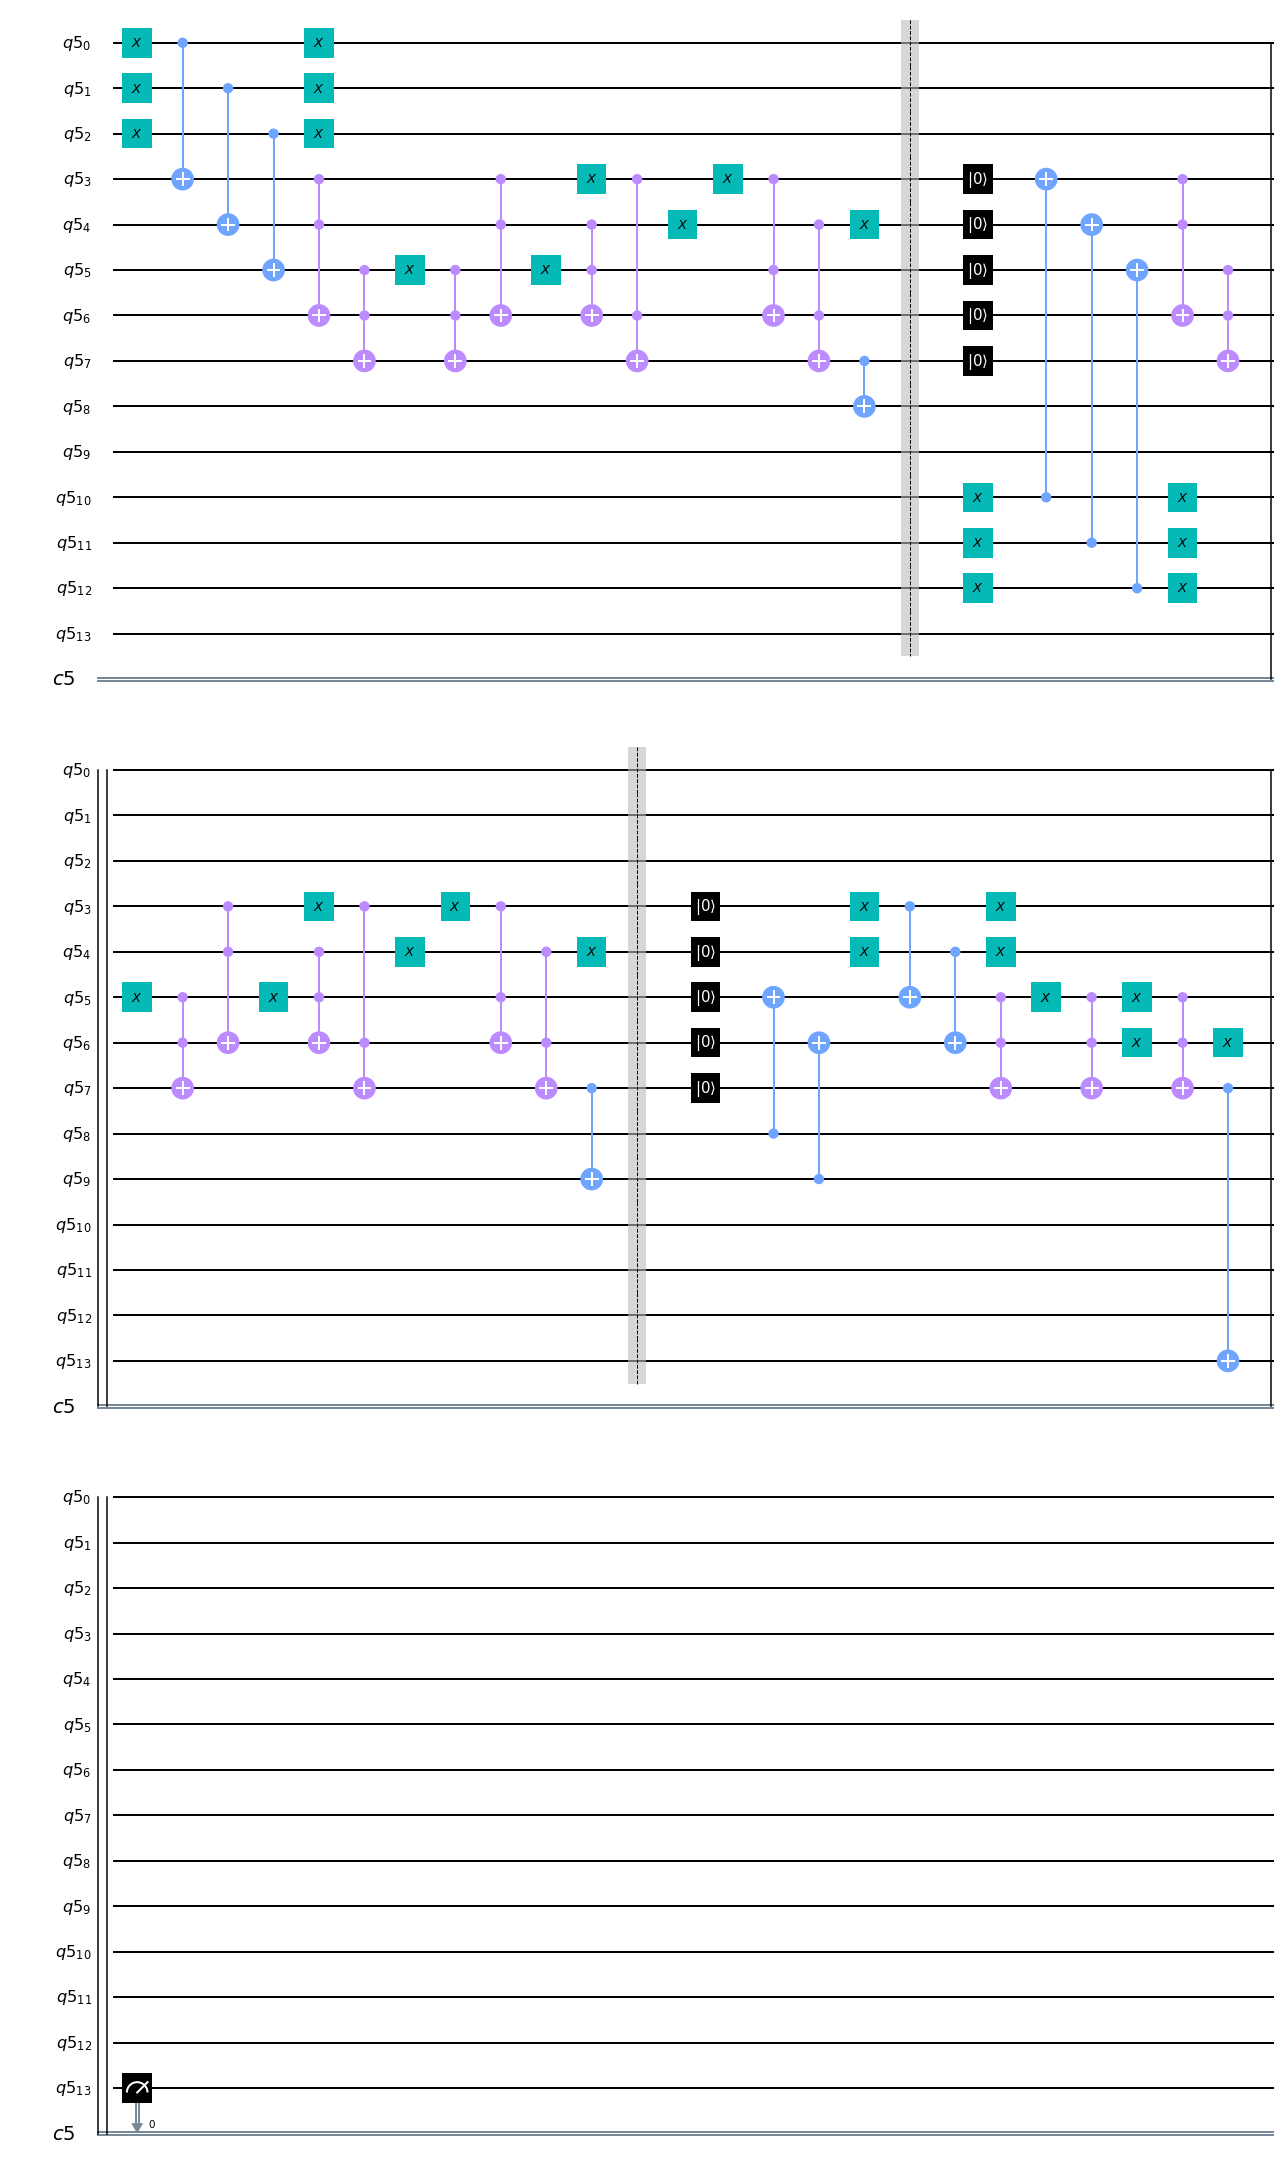

In [9]:
# Supondo que os valores iniciais são |0>
qWI = QuantumRegister(14) 
c = ClassicalRegister(1)
# Construindo o circuito
circuit = QuantumCircuit(qWI, c)
# Definindo a quantidade de inputs
qtd_input = 3

# Então, aqui temos a implementação do primeiro perceptron com 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i + qtd_input]) for i in range(qtd_input)]
activationFunction(circuit, qWI[3:8])
circuit.cx(qWI[7], qWI[8])

circuit.barrier()

circuit.reset(qWI[3:8])

# Vejamos o segundo perceptron que também tem 3 entradas.
[multiplyWeightInput(circuit, qWI[i], qWI[i - qtd_input - 4]) for i in range(10, 13)]
activationFunction(circuit, qWI[3:8])

circuit.cx(qWI[7], qWI[9])
circuit.barrier()
circuit.reset(qWI[3:8])
circuit.cx(qWI[8], qWI[5])
circuit.cx(qWI[9], qWI[6])
multiplyWeightInput(circuit, qWI[3], qWI[5])
multiplyWeightInput(circuit, qWI[4], qWI[6])
circuit.ccx(qWI[5], qWI[6], qWI[7])
circuit.x(qWI[5])
circuit.ccx(qWI[5], qWI[6], qWI[7])
circuit.x(qWI[5])
circuit.x(qWI[6])
circuit.ccx(qWI[5], qWI[6], qWI[7])
circuit.x(qWI[6])

circuit.cx(qWI[7],qWI[13])
circuit.measure(qWI[13], c[0])

# -----------------------------------------
# Ver o circuit desenhado
circuit.draw(output="mpl")

In [12]:
#Executando o circuito
backend = BasicAer.get_backend('qasm_simulator')
job = qiskit.execute(circuit, backend, shots=10)
result = job.result()
counts = result.get_counts(circuit)
print(counts)

{'0': 10}
